In [3]:
from pathlib import Path
import requests

In [4]:
DATA_PATH = Path("Data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [1]:
import pickle
import gzip

In [5]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
from matplotlib import pyplot
import numpy as np

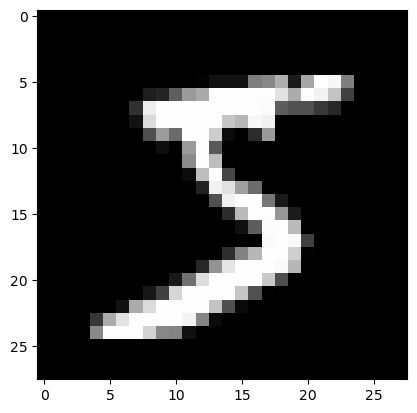

(50000, 784)


In [7]:
pyplot.imshow(x_train[0].reshape((28,28)), cmap='gray')
pyplot.show()
print(x_train.shape)

#### Convert numpy to torch.tensor

In [8]:
import torch

In [10]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
# print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

torch.Size([50000, 784])
tensor(0) tensor(9)


#### Neural Network from scratch (Without torch.nn)

In [31]:
import math

In [32]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad = True)

#### Activation function

In [33]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

#### Forward pass

In [34]:
bs = 64 # Batch size
xb = x_train[0:bs]  # Mini batch from x_train
preds = model(xb) # Predictions

print(preds[0], preds.shape)


tensor([-2.3365, -2.2838, -2.3672, -2.4209, -2.4518, -2.1343, -2.2797, -2.4201,
        -2.0129, -2.4128], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [35]:
print(xb.shape)
print(x_train.shape)
print(x_train[0:10].shape)

torch.Size([64, 784])
torch.Size([50000, 784])
torch.Size([10, 784])


#### Define Loss Function (Negative Log Likelihood)

In [36]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_fn = nll

#### Calculate Loss

In [37]:
yb = y_train[0:bs]
print(loss_fn(preds, yb))

tensor(2.4478, grad_fn=<NegBackward0>)


In [38]:
print(yb[0])

tensor(5)


#### Function to calculate Accuracy of the model

In [39]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim = 1)
    return (preds == yb).float().mean()

In [40]:
print(accuracy(preds, yb))

tensor(0.0938)


#### Training Loop

In [41]:
lr = 0.5 # Learning Rate
epochs = 2 # How many epochs to train for

for epoch in range(epochs):
    for i in range((n-1) // bs + 1): # For each batch
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)        
        loss = loss_fn(pred, yb) # Calculate loss
        
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()        
        

In [42]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NegBackward0>) tensor(1.)


#### Implementaing the Neural Network using torch.nn

In [43]:
import torch.nn.functional as F

In [44]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [45]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward0>) tensor(1.)


#### Refactor using nn.Module

In [46]:
from torch import nn

In [47]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [48]:
model = Mnist_Logistic()

In [49]:
print(loss_func(model(xb), yb))

tensor(2.3356, grad_fn=<NllLossBackward0>)


#### Training Loop uisng torch.nn

In [50]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()        

In [51]:
fit()

In [52]:
print(loss_func(model(xb), yb))

tensor(0.0786, grad_fn=<NllLossBackward0>)


#### Refactor using nn.Linear

In [53]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

In [54]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3282, grad_fn=<NllLossBackward0>)


In [55]:
fit()
print(loss_fn(model(xb), yb))

tensor(-8.3471, grad_fn=<NegBackward0>)


#### Refactor using torch.optim

In [56]:
from torch import optim

In [57]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [58]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.3819, grad_fn=<NllLossBackward0>)


In [59]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward0>)


#### Refactor using Dataset

In [60]:
from torch.utils.data import TensorDataset

In [61]:
train_ds = TensorDataset(x_train, y_train)

In [41]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward0>)


#### Refactor using DataLoader

In [65]:
from torch.utils.data import DataLoader

In [66]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [67]:
# The loop will use the DataLoader to iterate the data

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0808, grad_fn=<NllLossBackward0>)


#### Add Validation

In [68]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs ,shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [46]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss / len(valid_dl))


0 tensor(0.3139)
1 tensor(0.2826)


#### Further refactoring by creating fit() and get_data() functions

In [74]:
# loss_batch() function for computing training loss and validation loss

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [75]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

In [76]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2),
    )

In [77]:
# Now the whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3426383385181427
1 0.3085787388324738


#### Switching to CNN

In [78]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

#### Adding Momentum

In [79]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(),lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3337317136287689
1 0.2805014047622681


#### Using nn.Sequential

In [80]:
# Pytorch does not have a view layer, we need to define a custom layer from a given function

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [81]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x : x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.36729470658302305
1 0.258663553583622


#### Wrapping Dataloader

In [82]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [83]:
# Replace nn.AvgPool2D with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x : x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [84]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34237602610588075
1 0.2460009852528572


#### Using GPU

In [85]:
print(torch.cuda.is_available())

True


In [86]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [87]:
print(dev)

cuda


#### Update preprocess to move batches to cuda

In [89]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

#### Move model to GPU

In [90]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [92]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.15985668954253196
1 0.14420475814938546
